Loading and preprocessing dataset...
Extracting face features...
Splitting dataset into training and testing sets...
Training Eigenfaces model...
Evaluating model performance...
               precision    recall  f1-score   support

 image2\Hafid       0.43      1.00      0.60         3
   image2\Jim       1.00      0.33      0.50         3
image2\Lebron       0.00      0.00      0.00         3

     accuracy                           0.44         9
    macro avg       0.48      0.44      0.37         9
 weighted avg       0.48      0.44      0.37         9

Visualizing eigenfaces...


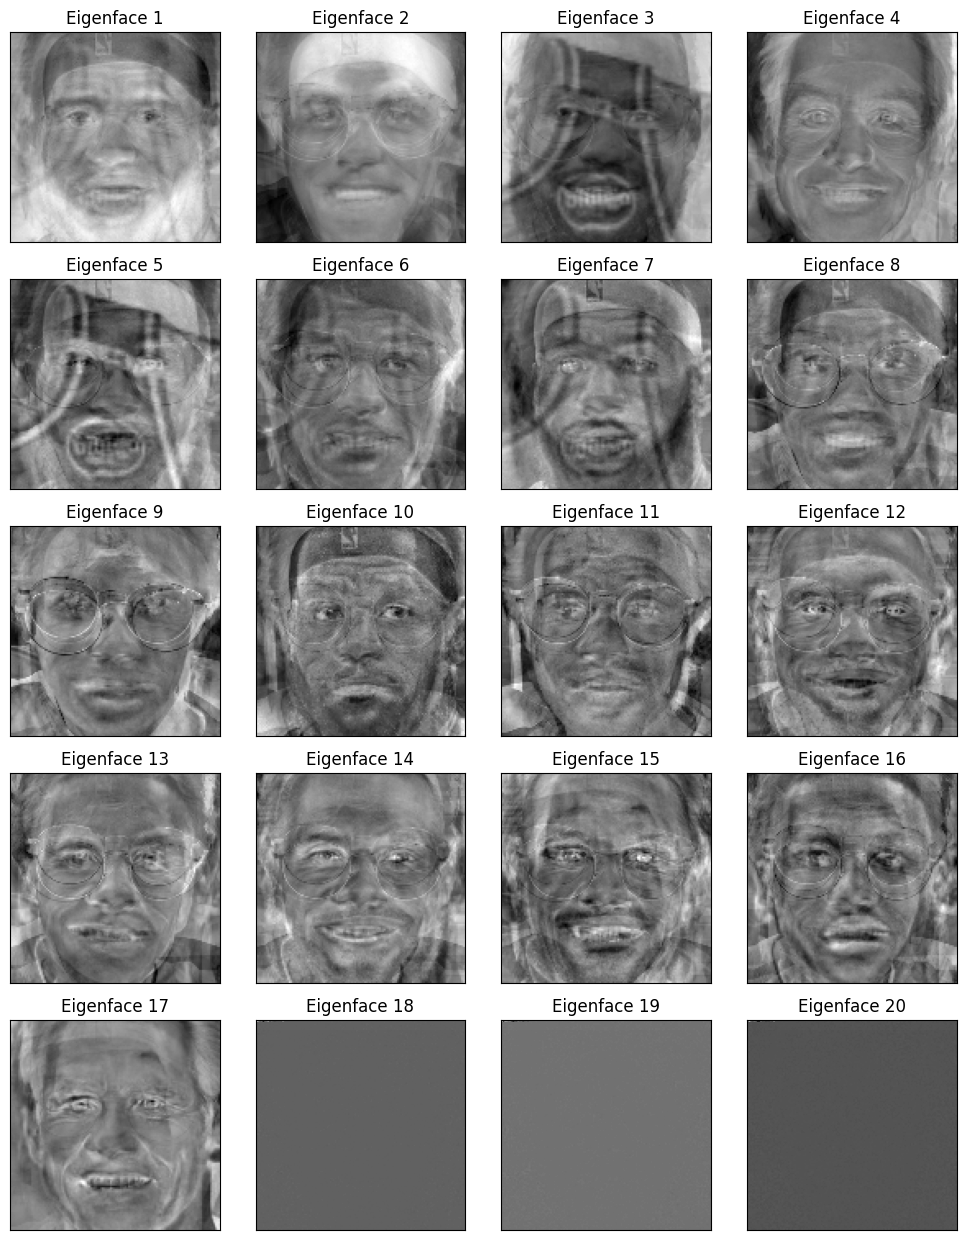

Saving model to eigenface_pipeline.pkl...
Model saved successfully.
Starting real-time face recognition...
Press 'q' to quit.
Face recognition system terminated.


In [2]:
"""
Face Recognition System using Eigenfaces

This program implements a face recognition system based on the Eigenfaces approach.
It uses Principal Component Analysis (PCA) for dimensionality reduction and
Support Vector Machines (SVM) for classification.

The system includes functionality for:
1. Loading and preprocessing face images
2. Detecting faces using Haar Cascade Classifier
3. Training an Eigenfaces model
4. Real-time face recognition using a webcam
"""

import os
import cv2
import numpy as np
import pickle
import matplotlib.pyplot as plt
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.svm import SVC
from sklearn.decomposition import PCA
from sklearn.metrics import classification_report


def load_image(image_path):
    """
    Load an image from the specified path and convert it to grayscale.
    
    Args:
        image_path (str): Path to the image file
        
    Returns:
        tuple: (original_image, grayscale_image) or (None, None) if loading fails
    """
    # Read the image from the given path
    original_image = cv2.imread(image_path)
    
    # Check if the image was successfully loaded
    if original_image is None:
        print(f'Error: Could not load image from {image_path}')
        return None, None
    
    # Convert the image to grayscale
    grayscale_image = cv2.cvtColor(original_image, cv2.COLOR_BGR2GRAY)
    
    return original_image, grayscale_image


def detect_faces(grayscale_image, scale_factor=1.1, min_neighbors=5, min_size=(30, 30)):
    """
    Detect faces in a grayscale image using the Haar Cascade classifier.

    Args:
        grayscale_image (ndarray): Grayscale image in which to detect faces
        scale_factor (float): Parameter specifying how much the image size is reduced at each scale
        min_neighbors (int): Parameter specifying minimum neighbors for each candidate rectangle
        min_size (tuple): Minimum possible object size (width, height)

    Returns:
        ndarray: Array of face rectangles, each represented as (x, y, width, height)
    """
    faces = face_cascade.detectMultiScale(
        grayscale_image,
        scaleFactor=scale_factor,
        minNeighbors=min_neighbors,
        minSize=min_size
    )
    return faces


def crop_faces(grayscale_image, faces, return_all=False):
    """
    Crop faces from a grayscale image based on detected face coordinates.

    Args:
        grayscale_image (ndarray): Grayscale image from which to crop faces
        faces (ndarray): Array of face rectangles, each represented as (x, y, width, height)
        return_all (bool): If True, return all detected faces; if False, return only the largest face

    Returns:
        tuple: (cropped_faces, selected_face_rectangles)
            - cropped_faces: List of cropped face images
            - selected_face_rectangles: List of rectangles corresponding to the cropped faces
    """
    cropped_faces = []
    selected_face_rectangles = []

    # Check if any faces were detected
    if len(faces) > 0:
        if return_all:
            # Crop all detected faces
            for x, y, width, height in faces:
                selected_face_rectangles.append((x, y, width, height))
                cropped_faces.append(grayscale_image[y:y+height, x:x+width])
        else:
            # Crop only the largest face (based on area)
            x, y, width, height = max(faces, key=lambda rect: rect[2] * rect[3])
            selected_face_rectangles.append((x, y, width, height))
            cropped_faces.append(grayscale_image[y:y+height, x:x+width])

    return cropped_faces, selected_face_rectangles


def resize_and_flatten(face_image, target_size=(128, 128)):
    """
    Resize a face image to the target size and flatten it into a 1D array.
    
    Args:
        face_image (ndarray): Face image to resize and flatten
        target_size (tuple): Target size (width, height) for resizing
        
    Returns:
        ndarray: Flattened face image as a 1D array
    """
    face_resized = cv2.resize(face_image, target_size)
    face_flattened = face_resized.flatten()
    return face_flattened


class MeanCentering(BaseEstimator, TransformerMixin):
    """
    Transformer that centers data by subtracting the mean face.
    
    This preprocessing step is crucial for PCA-based face recognition.
    """
    
    def fit(self, X, y=None):
        """
        Compute the mean face from the training data.
        
        Args:
            X (ndarray): Array of flattened face images
            y: Ignored (included for scikit-learn API compatibility)
            
        Returns:
            self: Returns self for method chaining
        """
        self.mean_face = np.mean(X, axis=0)
        return self
    
    def transform(self, X):
        """
        Subtract the mean face from each face image.
        
        Args:
            X (ndarray): Array of flattened face images
            
        Returns:
            ndarray: Mean-centered face images
        """
        return X - self.mean_face


def predict_label(face_gray, pipeline, target_size=(128, 128)):
    """
    Predict the identity label for a face image using the trained pipeline.
    
    Args:
        face_gray (ndarray): Grayscale face image
        pipeline: Trained scikit-learn pipeline for face recognition
        target_size (tuple): Target size (width, height) for resizing
        
    Returns:
        str: Predicted identity label
    """
    face_resized = cv2.resize(face_gray, target_size)
    face_flattened = face_resized.flatten().reshape(1, -1)
    label = pipeline.predict(face_flattened)[0]
    return label


# Define constants
DATASET_DIRECTORY = 'image2'  # Directory containing the dataset of images
FACE_SIZE = (128, 128)  # Standard size for face images
MODEL_FILENAME = 'eigenface_pipeline.pkl'  # Filename for saving the trained model

# Load the pre-trained Haar Cascade classifier for face detection
face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')

# Load dataset
print("Loading and preprocessing dataset...")
images = []  # List to store grayscale images
labels = []  # List to store corresponding identity labels

# Walk through the dataset directory
for root, dirs, files in os.walk(DATASET_DIRECTORY):
    if len(files) == 0:  # Skip directories with no files
        continue
    for file in files:
        _, grayscale_image = load_image(os.path.join(root, file))
        if grayscale_image is None:  # Skip if the image could not be loaded
            continue
        images.append(grayscale_image)
        labels.append(root.split('/')[-1])  # Label is the last part of the directory path

# Extract face features
print("Extracting face features...")
feature_vectors = []
feature_labels = []

for image, label in zip(images, labels):
    detected_faces = detect_faces(image)
    cropped_faces, _ = crop_faces(image, detected_faces)
    
    if len(cropped_faces) > 0:
        face_features = resize_and_flatten(cropped_faces[0], FACE_SIZE)
        feature_vectors.append(face_features)
        feature_labels.append(label)

# Convert lists to numpy arrays
feature_vectors = np.array(feature_vectors)
feature_labels = np.array(feature_labels)

# Split the dataset into training and testing sets
print("Splitting dataset into training and testing sets...")
X_train, X_test, y_train, y_test = train_test_split(
    feature_vectors, 
    feature_labels, 
    test_size=0.3, 
    random_state=177, 
    stratify=feature_labels  # Maintain class distribution
)

# Create and train the Eigenfaces pipeline
print("Training Eigenfaces model...")
eigenfaces_pipeline = Pipeline([
    ('centering', MeanCentering()),  # Mean centering step
    ('pca', PCA(svd_solver='randomized', whiten=True, random_state=177)),  # PCA step
    ('svm', SVC(kernel='linear', random_state=177))  # SVM classifier step
])

# Train the pipeline on the training data
eigenfaces_pipeline.fit(X_train, y_train)

# Evaluate the model
print("Evaluating model performance...")
y_pred = eigenfaces_pipeline.predict(X_test)
print(classification_report(y_test, y_pred))

# Visualize eigenfaces
print("Visualizing eigenfaces...")
n_components = len(eigenfaces_pipeline['pca'].components_)
n_cols = 4
n_rows = (n_components + n_cols - 1) // n_cols

fig, axes = plt.subplots(
    n_rows, n_cols, 
    figsize=(10, 2.5 * n_rows),
    subplot_kw={'xticks': [], 'yticks': []}
)

eigenfaces = eigenfaces_pipeline['pca'].components_.reshape((n_components, X_train.shape[1]))

for i, ax in enumerate(axes.flat[:n_components]):
    ax.imshow(eigenfaces[i].reshape(FACE_SIZE), cmap='gray')
    ax.set_title(f'Eigenface {i+1}')

plt.tight_layout()
plt.show()

# Save the trained model
print(f"Saving model to {MODEL_FILENAME}...")
with open(MODEL_FILENAME, 'wb') as model_file:
    pickle.dump(eigenfaces_pipeline, model_file)
print("Model saved successfully.")

# Real-time face recognition using webcam
print("Starting real-time face recognition...")
print("Press 'q' to quit.")

# Initialize webcam
video_capture = cv2.VideoCapture(0)

while True:
    # Capture frame-by-frame
    ret, frame = video_capture.read()
    if not ret:
        print("Failed to capture video frame. Exiting...")
        break

    # Detect faces in the current frame
    gray_frame = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    detected_faces = detect_faces(gray_frame)

    # Process each detected face
    for (x, y, width, height) in detected_faces:
        # Extract and predict the face
        face_region = gray_frame[y:y+height, x:x+width]
        predicted_label = predict_label(face_region, eigenfaces_pipeline, FACE_SIZE)
        
        # Draw rectangle and label on the frame
        cv2.rectangle(frame, (x, y), (x+width, y+height), (0, 255, 0), 2)
        cv2.putText(
            frame, 
            predicted_label, 
            (x, y-10),
            cv2.FONT_HERSHEY_SIMPLEX, 
            0.8, 
            (0, 255, 0), 
            2
        )

    # Display the resulting frame
    cv2.imshow("Eigenface Recognition", frame)

    # Break the loop when 'q' is pressed
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

# Clean up
video_capture.release()
cv2.destroyAllWindows()
print("Face recognition system terminated.")